In [3]:
import keras
import keras_cv
import tensorflow as tf
import matplotlib.pyplot as plt

import sys
from typing import Tuple

sys.path.append("..")

from dataloader import get_dataset


keras.utils.set_random_seed(123)
tfrecord_path = (
    "/home/sangohe/projects/pathology/data/TCGA_patches_224_56/fold0_train.tfrecord"
)


In [2]:
feature_desc = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "image_shape": tf.io.FixedLenFeature([3], tf.int64),
    "mask": tf.io.FixedLenFeature([], tf.string),
    "mask_shape": tf.io.FixedLenFeature([3], tf.int64),
}


def parse_example(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_desc)
    image = tf.io.parse_tensor(example["image"], tf.float32)
    image = tf.reshape(image, example["image_shape"])
    mask = tf.io.parse_tensor(example["mask"], tf.float32)
    mask = tf.reshape(mask, example["mask_shape"])
    return image, mask


def preprocessing(image, mask):
    image = image / 255.0
    return image, mask


def get_dataset(
    tfrecord_path: str,
    augmentations: bool = False,
    filter_non_zero_prob: float = 0.0,
    batch_size: int = 32,
    prefetch: bool = False,
    shuffle_size: int = 0,
) -> tf.data.Dataset:
    AUTOTUNE = tf.data.AUTOTUNE

    dset = tf.data.TFRecordDataset(tfrecord_path)
    dset = dset.map(parse_example, num_parallel_calls=AUTOTUNE)
    dset = dset.map(preprocessing, num_parallel_calls=AUTOTUNE)

    if augmentations:
        NUM_CLASSES = 2
        ROTATION_FACTOR = (-0.05, 0.05)
        augment = keras.Sequential(
            [
                keras_cv.layers.RandomFlip(),
                keras_cv.layers.RandomRotation(
                    factor=ROTATION_FACTOR,
                    segmentation_classes=NUM_CLASSES,
                ),
                # keras_cv.layers.RandAugment(
                #     value_range=(0, 1),
                #     geometric=False,
                # ),
            ]
        )

        def augmentation(
            image: tf.Tensor, mask: tf.Tensor
        ) -> Tuple[tf.Tensor, tf.Tensor]:
            inputs_dict = {
                "images": image,
                "segmentation_masks": tf.cast(mask, dtype=tf.int64),
            }
            augmented_data = augment(inputs_dict)
            return augmented_data["images"], augmented_data["segmentation_masks"]

        dset = dset.map(augmentation, num_parallel_calls=AUTOTUNE)

    if filter_non_zero_prob > 0:
        rng = tf.random.Generator.from_seed(123, alg="philox")

        def filter_non_zero(image, mask):
            seed = rng.make_seeds(2)[0]
            if tf.math.count_nonzero(mask) == 0:
                return tf.random.stateless_uniform([], seed) > filter_non_zero_prob
            return True

        dset = dset.filter(filter_non_zero)
    dset = dset.shuffle(shuffle_size) if shuffle_size else dset
    # dset = dset.batch(batch_size, num_parallel_calls=AUTOTUNE)
    dset = dset.prefetch() if prefetch else dset
    return dset


# Read the data

## Samples without filter or augmentations

2023-07-02 23:54:22.008988: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2023-07-02 23:54:22.009029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 1660b6c49a51
2023-07-02 23:54:22.009035: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 1660b6c49a51
2023-07-02 23:54:22.009119: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-07-02 23:54:22.009144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17
2023-07-02 23:54:22.671881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_AR

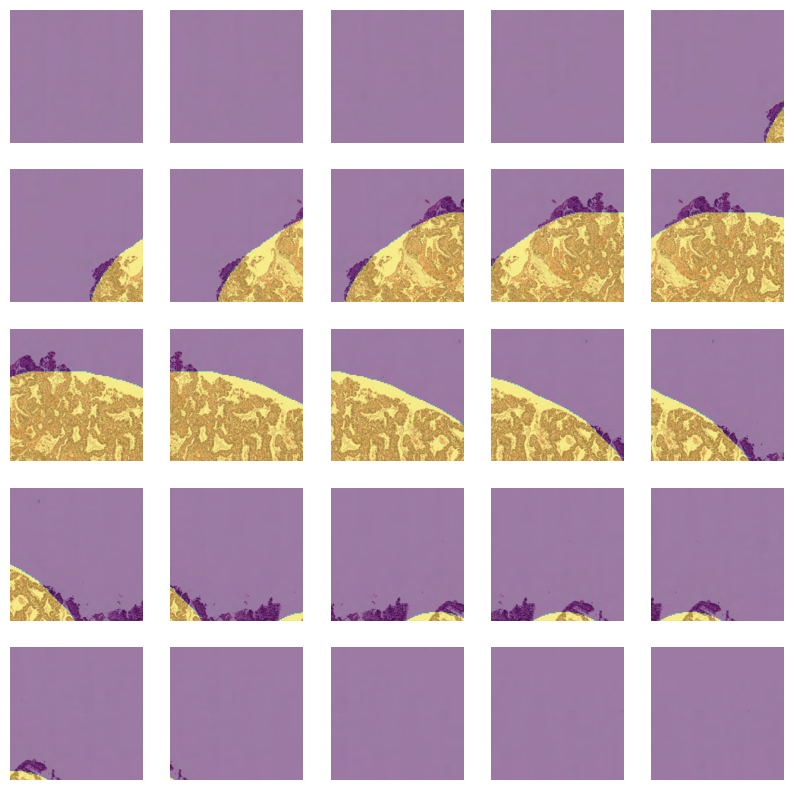

In [2]:
dset = get_dataset(tfrecord_path, filter_non_zero_prob=0.0)

# plot a 5x5 grid of images
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, (image, mask) in enumerate(dset.take(25)):
    axs[i // 5, i % 5].imshow(image.numpy())
    axs[i // 5, i % 5].imshow(mask.numpy(), alpha=0.5)
    axs[i // 5, i % 5].axis("off")


## Samples with filter

2023-07-02 23:54:43.919414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype resource
	 [[{{node Placeholder/_7}}]]
2023-07-02 23:54:43.919670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype resource
	 [[{{node Placeholder/_7}}]]


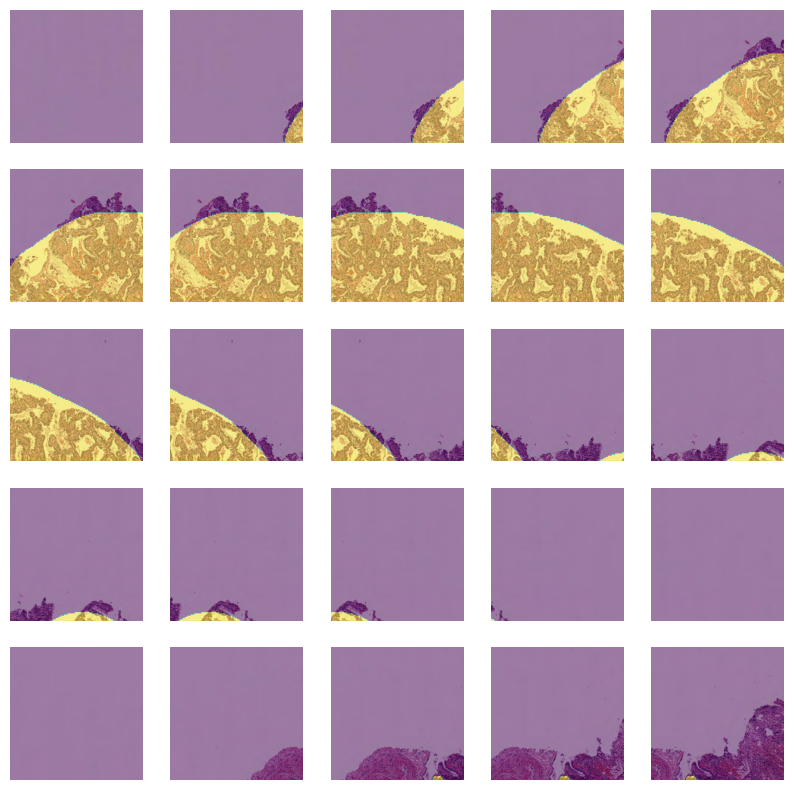

In [3]:
dset_filter = get_dataset(tfrecord_path, filter_non_zero_prob=0.8)

# plot a 5x5 grid of images
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, (image, mask) in enumerate(dset_filter.take(25)):
    axs[i // 5, i % 5].imshow(image.numpy())
    axs[i // 5, i % 5].imshow(mask.numpy(), alpha=0.5)
    axs[i // 5, i % 5].axis("off")


## Samples with augmentations

2023-07-03 00:03:34.989421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-03 00:03:34.989787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype resource
	 [[{{node Placeholder/_8}}]]


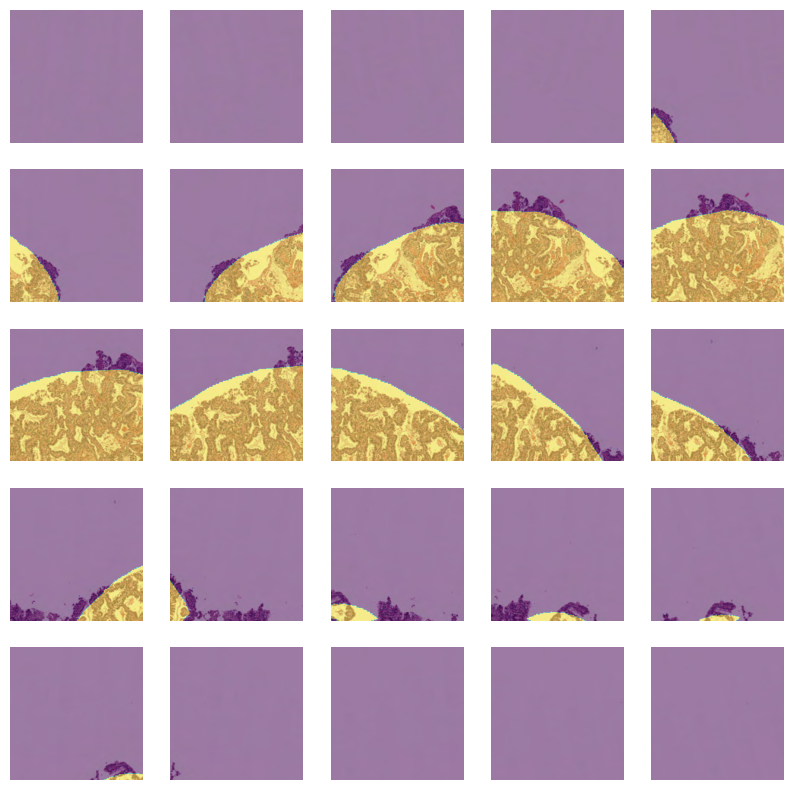

In [4]:
dset_aug = get_dataset(tfrecord_path, augmentations=True)

# plot a 5x5 grid of images
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, (image, mask) in enumerate(dset_aug.take(25)):
    axs[i // 5, i % 5].imshow(image.numpy())
    axs[i // 5, i % 5].imshow(mask.numpy(), alpha=0.5)
    axs[i // 5, i % 5].axis("off")


## Samples with filter and augmentations

2023-07-02 23:55:57.366485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-02 23:55:57.366788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype resource
	 [[{{node Placeholder/_11}}]]


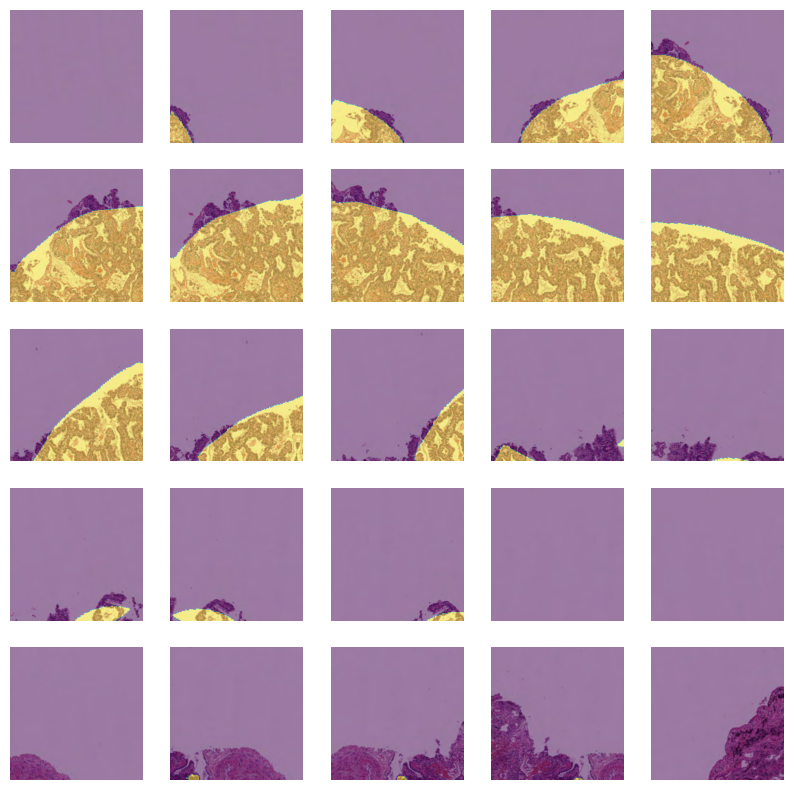

In [5]:
dset_filter_aug = get_dataset(
    tfrecord_path, augmentations=True, filter_non_zero_prob=0.8
)

# plot a 5x5 grid of images
fig, axs = plt.subplots(5, 5, figsize=(10, 10))
for i, (image, mask) in enumerate(dset_filter_aug.take(25)):
    axs[i // 5, i % 5].imshow(image.numpy())
    axs[i // 5, i % 5].imshow(mask.numpy(), alpha=0.5)
    axs[i // 5, i % 5].axis("off")
